# Query news and blog data

In [1]:
import numpy as np

#Get all country codes
import pycountry
iso = []
name = []
for e in list(pycountry.countries):
    iso.append(e.alpha_2)
    name.append(e.name)
    
name = np.array(name)
iso = np.array(iso)
iso = iso[np.argsort(name)]
name = name[np.argsort(name)]

countr = []
for i,e in enumerate(name):
    countr.append((e,iso[i]))

In [ ]:
from ipywidgets import Layout, Box, FloatText, Textarea, Dropdown, Label, Checkbox, SelectMultiple, Text, interact

form_item_layout = Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    align_content = "flex-start",
    width = "auto"
)

form_items = [
    Box([Label(value='Webhose Token',layout=Layout(width="auto")), Textarea(value = "76171c1e-faf9-4646-981e-10dda4eb680b")], layout=form_item_layout),
    Box([Label(value='Main query (in brackets)',layout=Layout(width="auto")), Textarea()], layout=form_item_layout),
    Box([Label(value='Language',layout=Layout(width="auto")),
         Dropdown(options=['english',"german"])], layout=form_item_layout),
    Box([Label(value='Is first (Exclude comments)',layout=Layout(width="auto")),
         Checkbox(value=True)], layout=form_item_layout),
    Box([Label(value='Performance score threshold (greater than x)',layout=Layout(width="auto")),
         FloatText(value = 1)], layout=form_item_layout),
    Box([Label(value='Domain Rank (Top x sites by monthly traffic)',layout=Layout(width="auto")),
         FloatText(value = 10000)], layout=form_item_layout),
     Box([Label(value='Published X days ago',layout=Layout(width="auto")),
         FloatText(value = 30)], layout=form_item_layout),
    Box([Label(value='Site type(s) (in brackets)',layout=Layout(width="auto")),
         Textarea(value='(site_type:news OR site_type:blogs)')], layout=form_item_layout),
    Box([Label(value='Sort by',layout=Layout(width="auto")),
         Dropdown(options={'Crawl Date': "crawled", 'Relevancy': "relevancy", 'Published': "published"})], layout=form_item_layout),
    Box([Label(value='All countries',layout=Layout(width="auto")),
         Checkbox(value=False)], layout=form_item_layout),
    Box([Label(value='Country'),
         SelectMultiple(options=countr,value = ["GB"],layout=Layout(display="flex", flex_flow='column'))], layout=form_item_layout),
    Box([Label(value='Other (thread.title or organization in brackets)',layout=Layout(width="auto")),
         Textarea()], layout=form_item_layout)
]

form = Box(form_items, layout=Layout(
    flex = "flex-basis",
    flex_flow='column',
    border='solid 1px',
    width='60%',
    height = "auto"
))
form

In [ ]:
#Queries
"""
(electric car OR electric cars OR autonomous driving OR autonomous car OR connected car)

((sport OR luxury) AND future AND (car sharing OR car rental OR car ownership OR car club OR car purchase OR car lease))

((sport OR luxury) AND future AND (car OR vehicle) AND (rent OR rental OR lease OR leasing OR own OR buy OR purchase OR club OR subscription OR share OR sharing))

"""

In [ ]:
# Set up query with form inputs
params = []
for el in form.children:
    params.append(el.children[1].value)
    
#Transform multi select countries
if params[-3]:
    params[-2]=""
else:    
    repl = []
    for i, c in enumerate(params[-2]):
        repl.append("thread.country:"+c)
    if len(params[-2])>1:
        params[-2] = "("+" OR ".join(repl)+")"
    else: 
        params[-2] = repl[0]

In [ ]:
#Build and run query
import webhoseio
import time
import datetime

webhoseio.config(token=params[0])
query_params = {"q":params[1]+" language:"+params[2]+" is_first:"+str(params[3]).lower()+" performance_score:>"+str(int(params[4]))+
                " domain_rank:<"+str(int(params[5]))+" "+params[7]+" "+params[10]+" "+params[11],
               "ts":str(int(time.mktime((datetime.datetime.now() + datetime.timedelta(-params[6])).timetuple()) * 1000)),
               "sort":params[8]}

output = webhoseio.query("filterWebContent", query_params)
print("Total number of documents: ",output['totalResults'])

In [ ]:
import pandas as pd

def get_list(obj,key):
    l = []
    for e in obj:
        l.append(e[key])
    return l

data = []

#Get all results to pandas dataframe
while True:
    
    if len(output["posts"]) != 0:
        for post in output['posts']:
            data.append({
                "entity_persons":get_list(post["entities"]["persons"],"name"),
                "entity_organizations":get_list(post["entities"]["organizations"],"name"),
                "entity_locations":get_list(post["entities"]["locations"],"name"),
                "uuid":post["uuid"],
                "author":post["author"],
                "url":post["url"],
                "language":post["language"],
                "title":post["title"],
                "highlightText":post["highlightText"],
                "text":post["text"],
                "publishedDate":post["published"],
                "crawledDate":post["crawled"],
                "fb_likes":post["thread"]["social"]["facebook"]["likes"],
                "fb_shares":post["thread"]["social"]["facebook"]["shares"],
                "linkedin_shares":post["thread"]["social"]["linkedin"]["shares"],
                "gplus_shares":post["thread"]["social"]["gplus"]["shares"],
                "source":post["thread"]["site_full"],
                "country":post["thread"]["country"],
                "performance_score":post["thread"]["performance_score"],
                "participants_counts":post["thread"]["participants_count"],
                "site_type":post["thread"]["site_type"]
                
            })
    else:
        break
        
    #Get next batch of data
    time.sleep(30)
    output = webhoseio.get_next()
    
data = pd.DataFrame.from_dict(data)
data.crawledDate = pd.to_datetime(data.crawledDate).dt.date
data.publishedDate = pd.to_datetime(data.publishedDate).dt.date

#Save data
data.to_csv("crypto.csv",header=True, index=False, encoding='utf-8',sep=";")

In [136]:
data["source"].unique()

array(['www.bloomberg.com', 'www.independent.co.uk',
       'www.theguardian.com', 'www.marketwatch.com',
       'www.rollingstone.com', 'www.businessinsider.com',
       'economictimes.indiatimes.com', 'www.forbes.com',
       'www.theatlantic.com', 'www.theverge.com', 'medium.com',
       'www.latimes.com', 'timesofindia.indiatimes.com', 'www.wired.com',
       'www.thedailybeast.com', 'www.reuters.com', 'www.wsj.com',
       'www.moneycontrol.com', 'news.abs-cbn.com', 'www.rt.com',
       'www.buzzfeed.com', 'www.cnet.com', 'www.bbc.com',
       'uk.businessinsider.com', 'www.msn.com', 'www.cnbc.com',
       'www.huffingtonpost.com', 'newsinfo.inquirer.net',
       'gadgets.ndtv.com', 'www.thehindu.com', 'business.inquirer.net',
       'www.europol.europa.eu', 'www.washingtonpost.com',
       'sg.news.yahoo.com', 'finance.yahoo.com', 'www.investing.com',
       'www.pcmag.com', 'abcnews.go.com', 'au.finance.yahoo.com',
       'www.reddit.com', 'www.foxnews.com', 'www.telegraph.co.uk

In [ ]:
data.columns

# Run topic model

In [2]:
import NewsTrends
import pandas as pd
import locale
#locale.setlocale(locale.LC_ALL, 'deu_deu')
%matplotlib inline

data = pd.read_csv("crypto.csv",sep=";",encoding='utf-8')
#data.date = pd.to_datetime(data.date,format="%d. %B %Y")
#data.shape

C:\Users\bockj\Anaconda3\lib\site-packages\gensim\utils.py:1167: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
t = NewsTrends.topicModel(data,
                          key_idx=list(data.columns).index("uuid"),
                          text_idx=list(data.columns).index("text"),
                          lang="en",random_state = 1,
                          bigram = True)

Train bigram model ...
mid april income_tax filing deadline contribute crypto fall price investor win big bet digital_token sell remain holding pay $_25 billion capital_gain levy tom_lee head_research fundstrat_global advisors write note thursday

bitcoin drop 40_percent past_month include 1.2 percent decline thursday $ 6,750 new_york close

massive outflow crypto dollar

lee write



In [4]:
tok_dat = t.tokenize_docs(rmv_tokens=["'s",'$',"mr","mr."])
corpus = t.get_bow(below = 0.05,above = 0.9)

INFO:lda:n_documents: 461
INFO:lda:vocab_size: 947
INFO:lda:n_words: 91367
INFO:lda:n_topics: 1
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -599646
INFO:lda:<10> log likelihood: -599646
INFO:lda:<20> log likelihood: -599646
INFO:lda:<30> log likelihood: -599646
INFO:lda:<40> log likelihood: -599646
INFO:lda:<50> log likelihood: -599646
INFO:lda:<60> log likelihood: -599646
INFO:lda:<70> log likelihood: -599646
INFO:lda:<80> log likelihood: -599646
INFO:lda:<90> log likelihood: -599646
INFO:lda:<100> log likelihood: -599646
INFO:lda:<110> log likelihood: -599646
INFO:lda:<120> log likelihood: -599646
INFO:lda:<130> log likelihood: -599646
INFO:lda:<140> log likelihood: -599646
INFO:lda:<150> log likelihood: -599646
INFO:lda:<160> log likelihood: -599646
INFO:lda:<170> log likelihood: -599646
INFO:lda:<180> log likelihood: -599646
INFO:lda:<190> log likelihood: -599646
INFO:lda:<200> log likelihood: -599646
INFO:lda:<210> log likelihood: -599646
INFO:lda:<220> log likelihood: -599

INFO:lda:<20> log likelihood: -642072
INFO:lda:<30> log likelihood: -636764
INFO:lda:<40> log likelihood: -634645
INFO:lda:<50> log likelihood: -632864
INFO:lda:<60> log likelihood: -631755
INFO:lda:<70> log likelihood: -630578
INFO:lda:<80> log likelihood: -630265
INFO:lda:<90> log likelihood: -630219
INFO:lda:<100> log likelihood: -629733
INFO:lda:<110> log likelihood: -628936
INFO:lda:<120> log likelihood: -628433
INFO:lda:<130> log likelihood: -628779
INFO:lda:<140> log likelihood: -628214
INFO:lda:<150> log likelihood: -628397
INFO:lda:<160> log likelihood: -627710
INFO:lda:<170> log likelihood: -627776
INFO:lda:<180> log likelihood: -627505
INFO:lda:<190> log likelihood: -627329
INFO:lda:<200> log likelihood: -627295
INFO:lda:<210> log likelihood: -627194
INFO:lda:<220> log likelihood: -626569
INFO:lda:<230> log likelihood: -626601
INFO:lda:<240> log likelihood: -627059
INFO:lda:<250> log likelihood: -626626
INFO:lda:<260> log likelihood: -626412
INFO:lda:<270> log likelihood: -6

INFO:lda:<60> log likelihood: -638100
INFO:lda:<70> log likelihood: -636539
INFO:lda:<80> log likelihood: -635429
INFO:lda:<90> log likelihood: -634222
INFO:lda:<100> log likelihood: -633611
INFO:lda:<110> log likelihood: -632431
INFO:lda:<120> log likelihood: -631757
INFO:lda:<130> log likelihood: -631684
INFO:lda:<140> log likelihood: -631796
INFO:lda:<150> log likelihood: -631410
INFO:lda:<160> log likelihood: -631180
INFO:lda:<170> log likelihood: -629539
INFO:lda:<180> log likelihood: -629726
INFO:lda:<190> log likelihood: -629693
INFO:lda:<200> log likelihood: -629170
INFO:lda:<210> log likelihood: -629004
INFO:lda:<220> log likelihood: -629024
INFO:lda:<230> log likelihood: -629174
INFO:lda:<240> log likelihood: -628780
INFO:lda:<250> log likelihood: -629209
INFO:lda:<260> log likelihood: -629479
INFO:lda:<270> log likelihood: -629546
INFO:lda:<280> log likelihood: -629302
INFO:lda:<290> log likelihood: -629094
INFO:lda:<300> log likelihood: -628466
INFO:lda:<310> log likelihood

INFO:lda:<100> log likelihood: -636115
INFO:lda:<110> log likelihood: -635711
INFO:lda:<120> log likelihood: -635227
INFO:lda:<130> log likelihood: -635049
INFO:lda:<140> log likelihood: -634657
INFO:lda:<150> log likelihood: -633935
INFO:lda:<160> log likelihood: -634152
INFO:lda:<170> log likelihood: -634251
INFO:lda:<180> log likelihood: -633559
INFO:lda:<190> log likelihood: -633176
INFO:lda:<200> log likelihood: -633436
INFO:lda:<210> log likelihood: -633106
INFO:lda:<220> log likelihood: -632946
INFO:lda:<230> log likelihood: -632529
INFO:lda:<240> log likelihood: -633743
INFO:lda:<250> log likelihood: -632305
INFO:lda:<260> log likelihood: -632036
INFO:lda:<270> log likelihood: -632248
INFO:lda:<280> log likelihood: -631762
INFO:lda:<290> log likelihood: -631774
INFO:lda:<300> log likelihood: -631568
INFO:lda:<310> log likelihood: -632147
INFO:lda:<320> log likelihood: -631287
INFO:lda:<330> log likelihood: -632336
INFO:lda:<340> log likelihood: -631370
INFO:lda:<350> log likeli

INFO:lda:<140> log likelihood: -635578
INFO:lda:<150> log likelihood: -635008
INFO:lda:<160> log likelihood: -634846
INFO:lda:<170> log likelihood: -634368
INFO:lda:<180> log likelihood: -634654
INFO:lda:<190> log likelihood: -634272
INFO:lda:<200> log likelihood: -633854
INFO:lda:<210> log likelihood: -633771
INFO:lda:<220> log likelihood: -633009
INFO:lda:<230> log likelihood: -633036
INFO:lda:<240> log likelihood: -632453
INFO:lda:<250> log likelihood: -632657
INFO:lda:<260> log likelihood: -632446
INFO:lda:<270> log likelihood: -632471
INFO:lda:<280> log likelihood: -633107
INFO:lda:<290> log likelihood: -632490
INFO:lda:<300> log likelihood: -631744
INFO:lda:<310> log likelihood: -631636
INFO:lda:<320> log likelihood: -631654
INFO:lda:<330> log likelihood: -631942
INFO:lda:<340> log likelihood: -631587
INFO:lda:<350> log likelihood: -631764
INFO:lda:<360> log likelihood: -632253
INFO:lda:<370> log likelihood: -631739
INFO:lda:<380> log likelihood: -631779
INFO:lda:<390> log likeli

INFO:lda:<180> log likelihood: -636487
INFO:lda:<190> log likelihood: -636237
INFO:lda:<200> log likelihood: -636782
INFO:lda:<210> log likelihood: -635936
INFO:lda:<220> log likelihood: -636276
INFO:lda:<230> log likelihood: -636740
INFO:lda:<240> log likelihood: -636150
INFO:lda:<250> log likelihood: -636694
INFO:lda:<260> log likelihood: -636030
INFO:lda:<270> log likelihood: -636216
INFO:lda:<280> log likelihood: -636627
INFO:lda:<290> log likelihood: -635410
INFO:lda:<300> log likelihood: -635706
INFO:lda:<310> log likelihood: -635850
INFO:lda:<320> log likelihood: -635782
INFO:lda:<330> log likelihood: -635007
INFO:lda:<340> log likelihood: -635771
INFO:lda:<350> log likelihood: -634817
INFO:lda:<360> log likelihood: -634658
INFO:lda:<370> log likelihood: -634791
INFO:lda:<380> log likelihood: -634187
INFO:lda:<390> log likelihood: -634386
INFO:lda:<400> log likelihood: -633279
INFO:lda:<410> log likelihood: -634077
INFO:lda:<420> log likelihood: -633796
INFO:lda:<430> log likeli

INFO:lda:<220> log likelihood: -638881
INFO:lda:<230> log likelihood: -638470
INFO:lda:<240> log likelihood: -637624
INFO:lda:<250> log likelihood: -637577
INFO:lda:<260> log likelihood: -637693
INFO:lda:<270> log likelihood: -637662
INFO:lda:<280> log likelihood: -637365
INFO:lda:<290> log likelihood: -636968
INFO:lda:<300> log likelihood: -636469
INFO:lda:<310> log likelihood: -636727
INFO:lda:<320> log likelihood: -636587
INFO:lda:<330> log likelihood: -636858
INFO:lda:<340> log likelihood: -636452
INFO:lda:<350> log likelihood: -637069
INFO:lda:<360> log likelihood: -636414
INFO:lda:<370> log likelihood: -635729
INFO:lda:<380> log likelihood: -635676
INFO:lda:<390> log likelihood: -636243
INFO:lda:<400> log likelihood: -636198
INFO:lda:<410> log likelihood: -636547
INFO:lda:<420> log likelihood: -636937
INFO:lda:<430> log likelihood: -636191
INFO:lda:<440> log likelihood: -636586
INFO:lda:<450> log likelihood: -636647
INFO:lda:<460> log likelihood: -636843
INFO:lda:<470> log likeli

INFO:lda:<260> log likelihood: -636539
INFO:lda:<270> log likelihood: -635927
INFO:lda:<280> log likelihood: -635403
INFO:lda:<290> log likelihood: -635203
INFO:lda:<300> log likelihood: -634034
INFO:lda:<310> log likelihood: -634870
INFO:lda:<320> log likelihood: -635355
INFO:lda:<330> log likelihood: -635858
INFO:lda:<340> log likelihood: -634751
INFO:lda:<350> log likelihood: -634996
INFO:lda:<360> log likelihood: -635053
INFO:lda:<370> log likelihood: -634451
INFO:lda:<380> log likelihood: -633479
INFO:lda:<390> log likelihood: -634018
INFO:lda:<400> log likelihood: -634183
INFO:lda:<410> log likelihood: -633758
INFO:lda:<420> log likelihood: -634512
INFO:lda:<430> log likelihood: -634435
INFO:lda:<440> log likelihood: -634404
INFO:lda:<450> log likelihood: -633804
INFO:lda:<460> log likelihood: -633965
INFO:lda:<470> log likelihood: -633579
INFO:lda:<480> log likelihood: -633700
INFO:lda:<490> log likelihood: -633418
INFO:lda:<500> log likelihood: -633125
INFO:lda:<510> log likeli

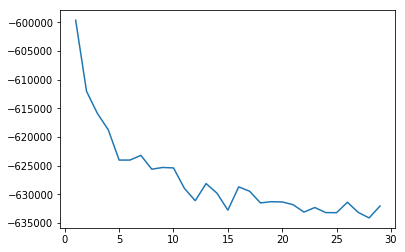

In [6]:
k,results = t.LDA_tune_k(max_k=30,iterations=1000)

In [5]:
#Train topic model
LDA = t.fit_LDA(12,iterations=5000)

INFO:lda:n_documents: 461
INFO:lda:vocab_size: 947
INFO:lda:n_words: 91367
INFO:lda:n_topics: 12
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -882722
INFO:lda:<10> log likelihood: -682248
INFO:lda:<20> log likelihood: -657447
INFO:lda:<30> log likelihood: -648925
INFO:lda:<40> log likelihood: -644385
INFO:lda:<50> log likelihood: -640942
INFO:lda:<60> log likelihood: -639500
INFO:lda:<70> log likelihood: -637588
INFO:lda:<80> log likelihood: -637519
INFO:lda:<90> log likelihood: -636031
INFO:lda:<100> log likelihood: -635909
INFO:lda:<110> log likelihood: -635001
INFO:lda:<120> log likelihood: -634224
INFO:lda:<130> log likelihood: -634237
INFO:lda:<140> log likelihood: -634315
INFO:lda:<150> log likelihood: -634488
INFO:lda:<160> log likelihood: -633643
INFO:lda:<170> log likelihood: -633720
INFO:lda:<180> log likelihood: -633399
INFO:lda:<190> log likelihood: -633447
INFO:lda:<200> log likelihood: -633511
INFO:lda:<210> log likelihood: -633533
INFO:lda:<220> log likelihood: -63

INFO:lda:<2040> log likelihood: -628519
INFO:lda:<2050> log likelihood: -628459
INFO:lda:<2060> log likelihood: -628544
INFO:lda:<2070> log likelihood: -628270
INFO:lda:<2080> log likelihood: -628425
INFO:lda:<2090> log likelihood: -628340
INFO:lda:<2100> log likelihood: -628557
INFO:lda:<2110> log likelihood: -629367
INFO:lda:<2120> log likelihood: -627756
INFO:lda:<2130> log likelihood: -627714
INFO:lda:<2140> log likelihood: -627656
INFO:lda:<2150> log likelihood: -627478
INFO:lda:<2160> log likelihood: -627473
INFO:lda:<2170> log likelihood: -626669
INFO:lda:<2180> log likelihood: -626617
INFO:lda:<2190> log likelihood: -626879
INFO:lda:<2200> log likelihood: -626706
INFO:lda:<2210> log likelihood: -627158
INFO:lda:<2220> log likelihood: -627085
INFO:lda:<2230> log likelihood: -627281
INFO:lda:<2240> log likelihood: -626679
INFO:lda:<2250> log likelihood: -627400
INFO:lda:<2260> log likelihood: -627615
INFO:lda:<2270> log likelihood: -627224
INFO:lda:<2280> log likelihood: -627243


INFO:lda:<4080> log likelihood: -627120
INFO:lda:<4090> log likelihood: -626927
INFO:lda:<4100> log likelihood: -627177
INFO:lda:<4110> log likelihood: -626814
INFO:lda:<4120> log likelihood: -627135
INFO:lda:<4130> log likelihood: -627048
INFO:lda:<4140> log likelihood: -626931
INFO:lda:<4150> log likelihood: -627114
INFO:lda:<4160> log likelihood: -627418
INFO:lda:<4170> log likelihood: -627984
INFO:lda:<4180> log likelihood: -627542
INFO:lda:<4190> log likelihood: -627529
INFO:lda:<4200> log likelihood: -627589
INFO:lda:<4210> log likelihood: -627462
INFO:lda:<4220> log likelihood: -627175
INFO:lda:<4230> log likelihood: -627497
INFO:lda:<4240> log likelihood: -627086
INFO:lda:<4250> log likelihood: -627196
INFO:lda:<4260> log likelihood: -626940
INFO:lda:<4270> log likelihood: -627375
INFO:lda:<4280> log likelihood: -626991
INFO:lda:<4290> log likelihood: -626911
INFO:lda:<4300> log likelihood: -626633
INFO:lda:<4310> log likelihood: -626985
INFO:lda:<4320> log likelihood: -627414


In [6]:
#Inspect topic results
topics = t.inspect_topics(n_top_words=5)

result = ''
for i, topic_words in enumerate(topics):
    result += '* **Topic {}:** {}\n'.format(i, ' '.join(topic_words))
NewsTrends.MD(result)

'* **Topic 0:** like people time come\n* **Topic 1:** company service business customer\n* **Topic 2:** blockchain bitcoin token create\n* **Topic 3:** trump play house new_york\n* **Topic 4:** site people website cryptocurrency\n* **Topic 5:** report russia state russian\n* **Topic 6:** bitcoin police system hacker\n* **Topic 7:** country year india china\n* **Topic 8:** facebook datum company ad\n* **Topic 9:** exchange cryptocurrency cryptocurrencie crypto\n* **Topic 10:** help system network project\n* **Topic 11:** bitcoin price year cryptocurrency\n'

In [ ]:
topics = [["Trump, new, report"],
          ["Company, new work, help, user"],
          ["business, blockchain, change, create, entrepreneur"],
          ["bitcoin,, police, hacker, steal, criminal"],
          ["facebook, user, data privacy, cambridge analytica"],
          ["fund, bank, invest, cryptocurrency"],
          ["crypto currency exchange, trading, bitcoin, price"],
          ["blockchain technology, platform, smart contracts, token"],
          ["people like, know, think, good thing"],
          ["government, security, attack, Russia, U.S., law, ban"]
          
         ]
len(topics)

In [41]:
#doctopics = t.get_doc_topic(topics)
#t.generate_network(node_attr=[ u'title',u'location'],
 #                 node_label="title", similarity_cutoff = 0.9,
  #               similarity_measure = "correlation")

In [7]:
doctopics = t.get_doc_topic(topics)
t.generate_network(node_attr=[ u'country', u'publishedDate',u'fb_likes', u'fb_shares',u'url',u"site_type"],
                  node_label="title", similarity_cutoff = 0.8,
                 similarity_measure = "correlation")

# Visualize

## Executive Summary

* Item 1
* Item 2

## Data Summary

In [9]:
import pprint
print("The data set contains {} stories.".format(data.shape[0]))
print()
print("The date range is {} to {}".format(data.publishedDate.min(),data.publishedDate.max()))
print()
print("Top sources include:")
print()
for a, b in enumerate(data.groupby("source")["uuid"].agg("count").sort_values(ascending=False)[0:5].keys(), 1):
    print('{} {}'.format(a, b))

The data set contains 461 stories.

The date range is 2018-04-03 to 2018-05-04

Top sources include:

1 www.independent.co.uk
2 www.cnbc.com
3 www.bloomberg.com
4 www.forbes.com
5 medium.com


In [33]:
#Plotly
import numpy as np
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from ipywidgets import widgets
from plotly.widgets import GraphWidget

plotly.offline.init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='bockjohannes@gmx.de', api_key='U8wOvUmXSdm9E9IB1l47')

## News monitor network

In [22]:
from IPython.core.display import HTML

HTML('<iframe src="graphs/network/index.html" width="1500" height="650" seamless>Netzwerk kann nicht angezeigt werden.</iframe>')

## Topics over time

### XXX.

In [70]:
# generate a function to handle changes in the widget
def timeline(y,date_col,colorby,aggregate="nunique",timeinterval=None):

    plot_dat = t.df.copy()
    plot_dat[date_col] = pd.to_datetime(plot_dat[date_col]).dt.week
        
    plot_dat = plot_dat.groupby([date_col,colorby])[y].agg(aggregate)
    dat = plot_dat.reset_index()
    
    dataset = []
    for gr in dat[colorby].unique():
        dataset.append(go.Bar(
        x=dat[dat[colorby]==gr][date_col],
        y=dat[dat[colorby]==gr][y],
        name=gr
    ))

    layout = go.Layout(
        autosize=False,
        width=800,
        height=550,
        barmode='stack',
        showlegend = True,
        legend=dict(orientation="h",x=0.1,y=1.5),
        yaxis = dict(title = y+" ("+aggregate+")"),
        xaxis = dict(title=date_col)
    )
    
    
    fig = go.Figure(data=dataset, layout=layout)
    return py.iplot(fig, filename='stacked-bar')

timeline(y="uuid", date_col = 'publishedDate',colorby="topic_terms",aggregate="nunique")

## Histogram

### XXX.

In [71]:
# generate a function to handle changes in the widget
def hist(x,colorby="topic_terms",logx = False):

    plot_dat = t.df.copy()
    
    if logx:
        plot_dat[x]=np.log(plot_dat[x])
        #typ = 'log'
    #else:
        #typ="normal"
    data = []
    for gr in plot_dat[colorby].unique():
        data.append(go.Histogram(
            x=plot_dat.loc[plot_dat[colorby]==gr,x],
            name=gr
            
    ))

    layout = go.Layout(barmode='stack',legend=dict(orientation="h",x=0.1,y=1.5),
                       autosize=False,
                width=800,
                height=550,
                       xaxis=dict(title=x,type="normal",autorange=True,
                                 exponentformat= "e" if logx else "none"),
                      yaxis = dict(title="count"))
    fig = go.Figure(data=data, layout=layout)

    
    return py.iplot(fig, filename='stacked histogram')

hist(x='fb_likes',colorby="topic_terms",logx=True)

## Bar Chart

### XXX.

In [72]:
def bar(x,groupby,colorby = None, aggregate = "sum"):
    plot_dat = t.df.copy()
    
    if colorby == None:
        plot_dat = plot_dat.groupby(groupby)[x].agg(aggregate)
        data =[
            go.Bar(
            y=plot_dat.index.values,
            x=plot_dat.values,
            orientation = 'h')
        ]
        fig = go.Figure(data=data)
    else:
        data = []
        plot_dat = plot_dat.groupby([colorby,groupby])[x].agg(aggregate)
        for gr in plot_dat.index.levels[0]: 
            data.append(go.Bar(
            y=plot_dat[gr].index.values,
            x=plot_dat[gr].values,
            name=gr,
            orientation = 'h'
        ))
        
        layout = go.Layout(
            autosize=False,
        width=800,
        height=550,
            barmode='stack',
            showlegend = True,
            xaxis = dict(title=x+" ("+aggregate+")",position=-1.),
            yaxis = dict(),
            legend=dict(orientation="h",x=0.1,y=1.2),
            margin = go.Margin(l=330,r=50)
        )
      
        fig = go.Figure(data=data, layout=layout)
    
    return py.iplot(fig, filename='bar')

bar(x="uuid",groupby="topic_terms",colorby="country",aggregate="nunique")

## Scatter plot

### There is a linear relationship between number of articles published and the popularity of the topic in social media.

In [73]:
def scatter(x,y,groupby,colorby = None,sizeby = "fixed", aggregate = {"x":"sum","y":"sum","colorby":"sum"},
            axistype = {"x":"normal","y":"normal"},
            xtitle="", ytitle=""):
    
    plot_dat = t.df.copy()
    if sizeby=="fixed":
        s=15
    if colorby == None:
        colorby = groupby
        
    if plot_dat[colorby].dtype == np.object:
        plot_datx = plot_dat.groupby([colorby,groupby])[x].agg(aggregate["x"])
        plot_daty = plot_dat.groupby([colorby,groupby])[y].agg(aggregate["y"])
        
        dat = []
        for cat in plot_dat[colorby].unique():
            
            dat.append({"x":plot_datx[cat].values,
                       "y":plot_daty[cat].values,
                        "text":plot_daty[cat].index,
                       "name":cat,
                       "mode":"markers",
                       "marker":dict(size=s)})
        fig = {
            'data': dat,
            'layout': {"legend":dict(orientation="h",x=0.1,y=1.5),"showlegend": True,
                'xaxis': {'title': xtitle,"type":axistype["x"],"exponentformat": "e" if axistype["x"]=="log" else "none"},
                'yaxis': {'title': ytitle,"type":axistype["y"],"exponentformat": "e" if axistype["y"]=="log" else "none"},
                "autosize":False,
                "width":800,
                "height":550,
            }
        }
    else:
        plot_datx = plot_dat.groupby(groupby)[x].agg(aggregate["x"])
        plot_daty = plot_dat.groupby(groupby)[y].agg(aggregate["y"])
        plot_datcol = plot_dat.groupby(groupby)[colorby].agg(aggregate["colorby"])
        
        trace1 = go.Scatter(
            y = plot_daty.values,
            x = plot_datx.values,
            mode='markers',
            marker=dict(
                size=s,
                color = plot_datcol.values, #set color equal to a variable
                colorscale='Viridis',
                showscale=True
            )
        )
        layout = dict(xaxis=dic(title=xtitle,type=axistype["x"],exponentformat= "e" if axistype["x"]=="log" else "none"),
                      yaxis=dic(title=ytitle,type=axistype["y"],exponentformat= "e" if axistype["y"]=="log" else "none"))
        fig = go.Figure(data=[trace1],layout = layout)
        
    return py.iplot(fig, filename='bar')

scatter(x="uuid",y='fb_likes',groupby="topic_terms",colorby = "topic_terms",
        sizeby = "fixed",xtitle="Publish-Count",ytitle="fb-likes",
        axistype=dict(x="normal",y="normal"),
        aggregate = {"x":"nunique","y":"sum","colorby":"sum"})

In [74]:
# jupyter nbconvert News_feed.ipynb --to slides --template output_toggle 
## --post serve
# http://nbviewer.jupyter.org/format/slides/github/bockjo/Udacity_portfolio/blob/master/filename.ipynb

In [75]:
from plotly.graph_objs import *
trace0 = Scatter(
    x=[1, 2, 3, 4],
    y=[10, 15, 13, 17]
)
trace1 = Scatter(
    x=[1, 2, 3, 4],
    y=[16, 5, 11, 9]
)
data = Data([trace0, trace1])

py.iplot(data, filename = 'basic-line')